### Problem statement
Leveraging the data of LoanTap, find out which factors are important in building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals. We are focusing on the underwriting process behind Personal Loan only

In [119]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,recall_score,precision_score,ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the dataset
df = pd.read_csv("D:/Scaler/Projects/logistic_regression.csv")

In [3]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [4]:
#Checking the shape of the data
df.shape

(396030, 27)

###### There are 396030 rows and 27 columns in the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [6]:
df.describe().round(2)

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,395754.00,396030.00,358235.00,395495.00
mean,14113.89,13.64,431.85,74203.18,17.38,11.31,0.18,15844.54,53.79,25.41,1.81,0.12
std,8357.44,4.47,250.73,61637.62,18.02,5.14,0.53,20591.84,24.45,11.89,2.15,0.36
min,500.00,5.32,16.08,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,10.49,250.33,45000.00,11.28,8.00,0.00,6025.00,35.80,17.00,0.00,0.00
50%,12000.00,13.33,375.43,64000.00,16.91,10.00,0.00,11181.00,54.80,24.00,1.00,0.00
75%,20000.00,16.49,567.30,90000.00,22.98,14.00,0.00,19620.00,72.90,32.00,3.00,0.00
max,40000.00,30.99,1533.81,8706582.00,9999.00,90.00,86.00,1743266.00,892.30,151.00,34.00,8.00


###### Columns Loan Amount, Installments, Annual Income and revol_bal have difference in their mean and median so outliers are present in the data 

In [7]:
df.describe(include = 'object')

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address
count,396030,396030,396030,373103,377729,396030,396030,396030,396030,396030,394275,396030,396030,396030,396030
unique,2,7,35,173105,11,6,3,115,2,14,48817,684,2,3,393700
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,Oct-2000,f,INDIVIDUAL,USCGC Smith\r\nFPO AE 70466
freq,302005,116018,26655,4389,126041,198348,139563,14846,318357,234507,152472,3017,238066,395319,8


In [8]:
#Checking for missing values
(df.isna().sum()/len(df)*100).sort_values(ascending = False)

mort_acc                9.543469
emp_title               5.789208
emp_length              4.621115
title                   0.443148
pub_rec_bankruptcies    0.135091
revol_util              0.069692
loan_amnt               0.000000
dti                     0.000000
application_type        0.000000
initial_list_status     0.000000
total_acc               0.000000
revol_bal               0.000000
pub_rec                 0.000000
open_acc                0.000000
earliest_cr_line        0.000000
purpose                 0.000000
term                    0.000000
loan_status             0.000000
issue_d                 0.000000
verification_status     0.000000
annual_inc              0.000000
home_ownership          0.000000
sub_grade               0.000000
grade                   0.000000
installment             0.000000
int_rate                0.000000
address                 0.000000
dtype: float64

###### We can see there is some missing data present in our dataset 

In [9]:
#Dropping duplicate rows if present
df.drop_duplicates(inplace = True)
df.shape

(396030, 27)

###### Shape of data didn't change aftere dropping duplicate rows so no duplicate rows in our data

In [10]:
df.nunique()

loan_amnt                 1397
term                         2
int_rate                   566
installment              55706
grade                        7
sub_grade                   35
emp_title               173105
emp_length                  11
home_ownership               6
annual_inc               27197
verification_status          3
issue_d                    115
loan_status                  2
purpose                     14
title                    48817
dti                       4262
earliest_cr_line           684
open_acc                    61
pub_rec                     20
revol_bal                55622
revol_util                1226
total_acc                  118
initial_list_status          2
application_type             3
mort_acc                    33
pub_rec_bankruptcies         9
address                 393700
dtype: int64

In [11]:
cat_cols = ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status',
            'initial_list_status', 'application_type', 'pub_rec_bankruptcies']

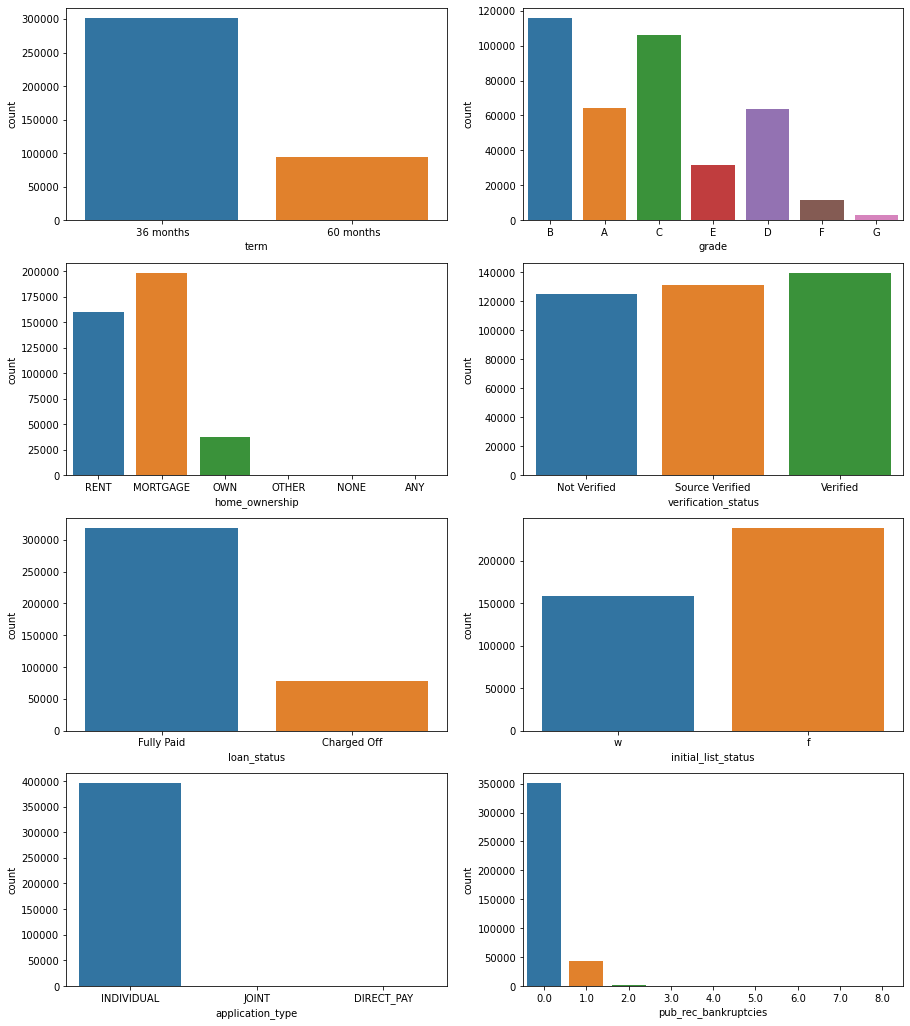

In [12]:
#Analysis of categorical columns by countplot
Fig, Axes = plt.subplots(nrows=4, ncols=2, figsize=(15,18))
k = 0
for i in range(4):
    for j in range(2):
        sns.countplot(data=df, x= cat_cols[k], ax=Axes[i,j])
        k += 1
plt.show()

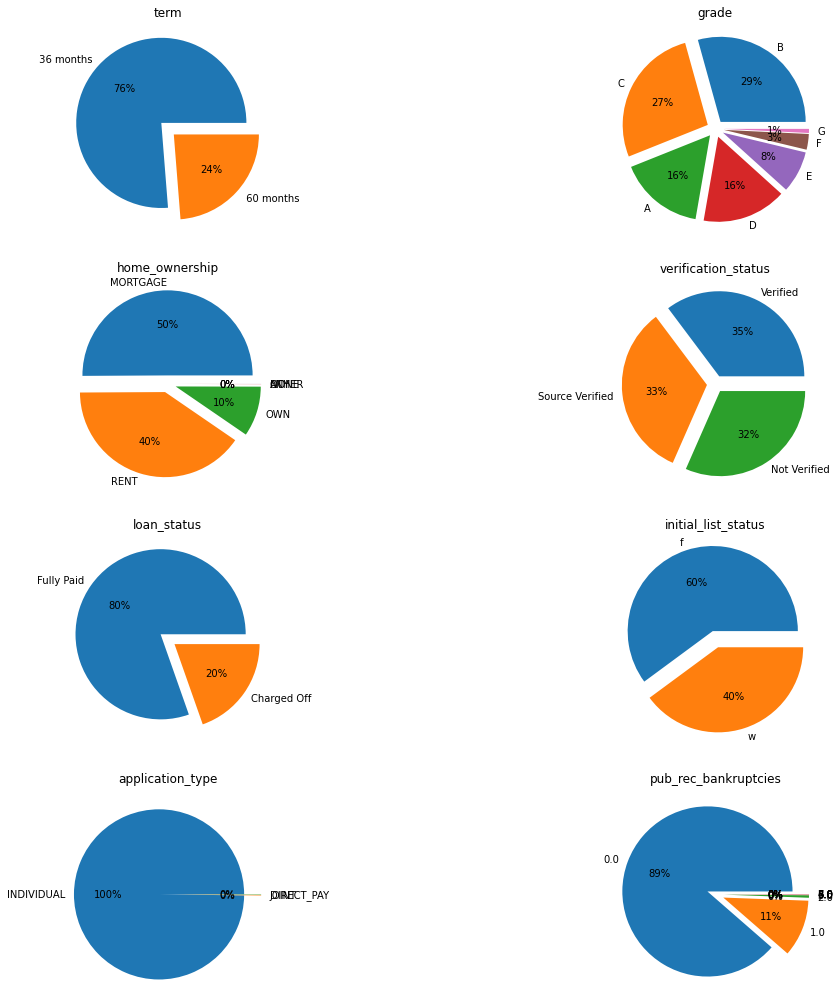

In [13]:
#Proportion analysis by pie chart of categorical columns
plt.figure(figsize = (18,18))
k = 0
for i in range(8):
    plt.subplot(4, 2, i+1)
    data = df[cat_cols[i]].value_counts(normalize=True)*100
    explode = [0.1]*len(data.index)
    plt.gca().title.set_text(cat_cols[i])
    plt.pie(x=data.values, labels=data.index, autopct='%.0f%%', explode= explode)
    k += 1

###### We can see that 76% data is of term 36 months
###### Maximum 29% data is of loan grade B, followed by C with 27% data 
###### In the home ownership, 50% of data is of mortgage followed by rent 40%
###### 35% data is of the verified income by LoanTap, 33% data of verified income source and rest 32% is not verified data
###### 80% data is of fully paid loans and 20 % data of charged off loans
###### 60% data is of F(full) as initial list status 
###### The dataset has almost all the data of individual application type
###### 89% data with zero number of public record bankruptcies

## Feature Understanding

### Loan Amount

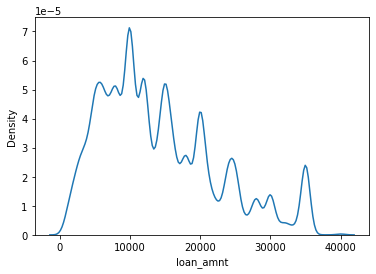

In [14]:
sns.kdeplot(df['loan_amnt'])
plt.show()

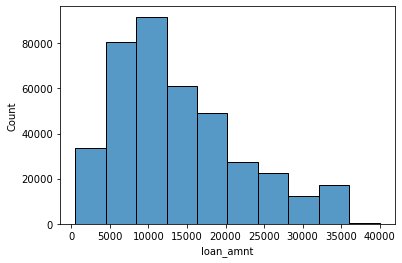

In [15]:
sns.histplot(df['loan_amnt'], bins = 10)
plt.show()

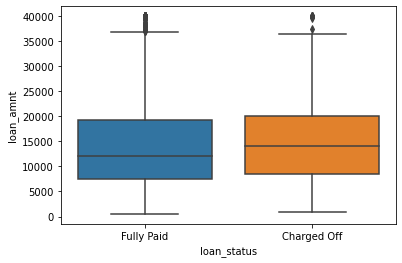

In [16]:
sns.boxplot(y=df["loan_amnt"], x=df["loan_status"])
plt.show()

###### The maximum loan amount is 40,000 and the minimum is 1,000. The distribution is not normal, has multiple peaks, and there are some outliers at the right tail
######  For loan status Charged_off, the mean and median of loan_amount is higher than fully paid

### Term

In [17]:
pd.crosstab(index=df["term"],columns=df["loan_status"], normalize="index", margins  = True) * 100

loan_status,Charged Off,Fully Paid
term,,
36 months,15.774573,84.225427
60 months,31.941505,68.058495
All,19.612908,80.387092


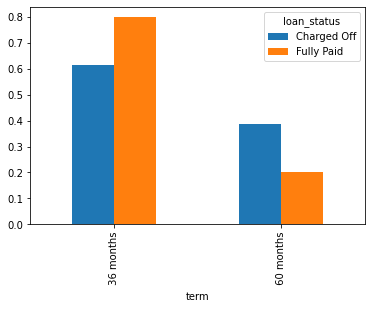

In [18]:
pd.crosstab(index=df["term"],columns =df["loan_status"], normalize="columns").plot(kind = "bar")
plt.show()

###### We can see that the conditional probability of loan fully paid given that its 36 month term is higher then charged off. Loan fully paid probability when 60 month term is lower than charged off.

### Interest Rate

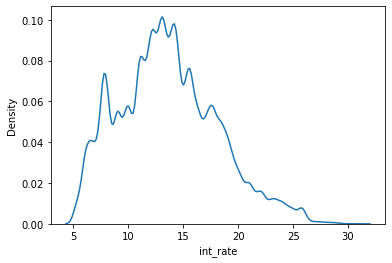

In [19]:
sns.kdeplot(df['int_rate'])
plt.show()

In [20]:
df.groupby(by = "loan_status")["int_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15.882587,4.388135,5.32,12.99,15.61,18.64,30.99
Fully Paid,318357.0,13.092105,4.319105,5.32,9.91,12.99,15.61,30.99


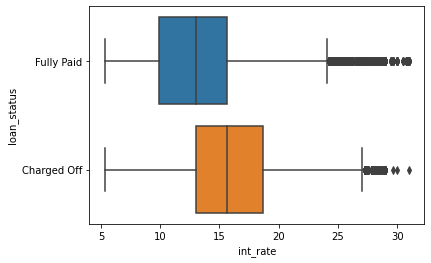

In [21]:
sns.boxplot(x=df["int_rate"],y=df["loan_status"])
plt.show()

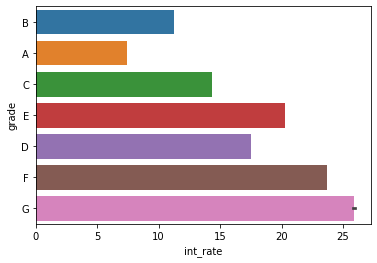

In [22]:
sns.barplot(x=df["int_rate"],y=df["grade"])
plt.show()

###### The range of interest rate on the loans is quite wide, from 5.32% to 30.99%. Again, we see that the distribution is not normal, has multiple peaks, and there are some outliers at the right tail. The lower the loan grade, the higher the interest rate. 

### Installment

In [23]:
df['installment'].describe()

count    396030.000000
mean        431.849698
std         250.727790
min          16.080000
25%         250.330000
50%         375.430000
75%         567.300000
max        1533.810000
Name: installment, dtype: float64

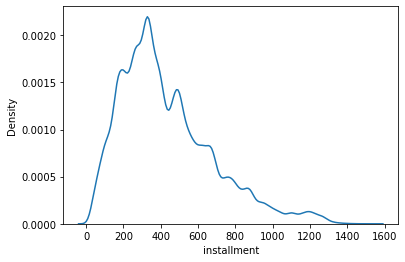

In [24]:
sns.kdeplot(df['installment'])
plt.show()

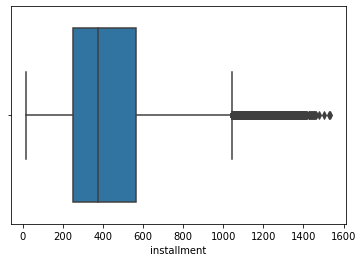

In [25]:
sns.boxplot(x=df["installment"])
plt.show()

###### The range of installments is wide, from 16.08 to 1533.81 per month. The mean is 431.84. Obviously, one would expect the installments to be highly correlated to the loan amount, as we can see from the simple correlation heatmap below.

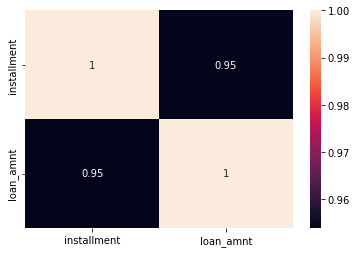

In [26]:
sns.heatmap(df[['installment', 'loan_amnt']].corr(), annot = True)
plt.show()

### Grade

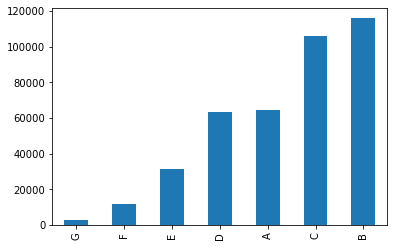

In [27]:
df["grade"].value_counts().sort_values().plot(kind = "bar")
plt.show()

In [28]:
df["grade"].value_counts(dropna=False)

B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: grade, dtype: int64

In [29]:
pd.crosstab(index = df["grade"],columns= df["loan_status"],normalize= "index", margins = True)

loan_status,Charged Off,Fully Paid
grade,,
A,0.062879,0.937121
B,0.125730,0.874270
C,0.211809,0.788191
D,0.288678,0.711322
E,0.373634,0.626366
F,0.427880,0.572120
G,0.478389,0.521611
All,0.196129,0.803871


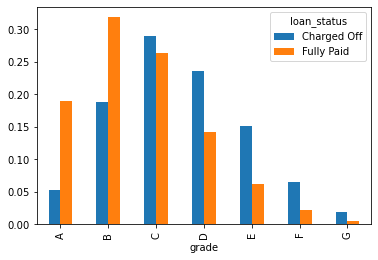

In [30]:
pd.crosstab(index = df["grade"],columns= df["loan_status"],normalize= "columns").plot(kind  = "bar")
plt.show()

###### We can see that probability of loan_status as fully_paid decreases with grade E,F,G

### Employee Title 

In [31]:
df["emp_title"].value_counts(dropna=False).sort_values(ascending=False).head(15)

NaN                 22927
Teacher              4389
Manager              4250
Registered Nurse     1856
RN                   1846
Supervisor           1830
Sales                1638
Project Manager      1505
Owner                1410
Driver               1339
Office Manager       1218
manager              1145
Director             1089
General Manager      1074
Engineer              995
Name: emp_title, dtype: int64

In [32]:
df['emp_title'].describe()

count      373103
unique     173105
top       Teacher
freq         4389
Name: emp_title, dtype: object

######  Missing values need to be treated with model based imputation. Total unique job_titles are 173,105. We can see that teacher and manager are two affordable job titles

### Emplyoement Length

In [33]:
df["emp_length"].value_counts(dropna=False)

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
NaN           18301
9 years       15314
Name: emp_length, dtype: int64

In [34]:
pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,Charged Off,Fully Paid
emp_length,,
1 year,19.913453,80.086547
10+ years,18.418610,81.581390
2 years,19.326206,80.673794
3 years,19.523133,80.476867
4 years,19.238477,80.761523
5 years,19.218721,80.781279
6 years,18.919438,81.080562
7 years,19.477400,80.522600
8 years,19.976002,80.023998


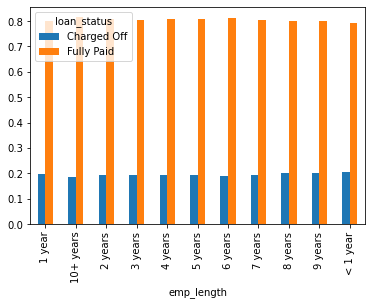

In [35]:
pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")
plt.show()

###### Visually there doent seems to be much correlation between employement length 

### Home Ownership

In [36]:
df["home_ownership"].value_counts(dropna=False)

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [37]:
df["home_ownership"] = df["home_ownership"].replace({"NONE":"OTHER", "ANY":"OTHER"})

In [38]:
pd.crosstab(index = df["home_ownership"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,16.956057,83.043943
OTHER,15.753425,84.246575
OWN,20.680337,79.319663
RENT,22.662244,77.337756
All,19.612908,80.387092


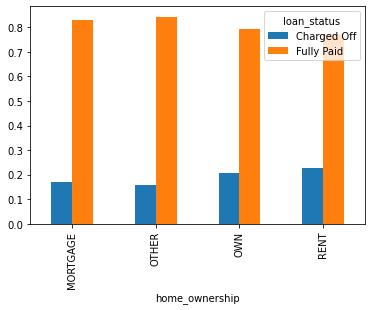

In [39]:
pd.crosstab(index = df["home_ownership"],
            columns= df["loan_status"],normalize= "index").plot(kind= "bar")
plt.show()

###### Visually there doent seems to be much correlation between home_ownership and loan_status.

### Annual Income

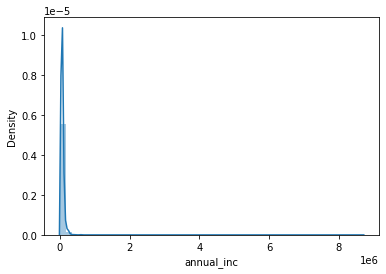

In [40]:
sns.distplot(df["annual_inc"])
plt.show()

In [41]:
df["annual_inc"].describe()

count    3.960300e+05
mean     7.420318e+04
std      6.163762e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.400000e+04
75%      9.000000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64

<AxesSubplot:xlabel='annual_inc', ylabel='Density'>

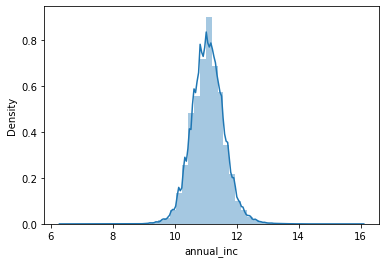

In [42]:
sns.distplot(np.log(df[df["annual_inc"]>0]["annual_inc"]))

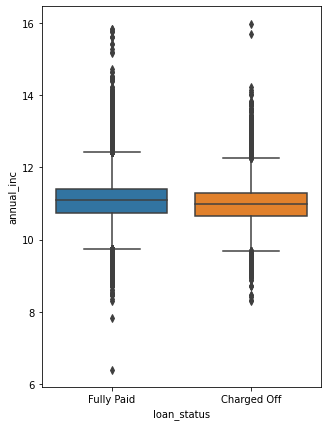

In [43]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(df[df["annual_inc"]>0]["annual_inc"]),
            x=df["loan_status"])
plt.show()

###### From above boxplot, there seems to be no difference between annual income for loan status categories 


### Varification Status

In [44]:
df["verification_status"].value_counts(dropna=False)

Verified           139563
Source Verified    131385
Not Verified       125082
Name: verification_status, dtype: int64

In [45]:
pd.crosstab(index = df["verification_status"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,Charged Off,Fully Paid
verification_status,,
Not Verified,14.635999,85.364001
Source Verified,21.474293,78.525707
Verified,22.321102,77.678898
All,19.612908,80.387092


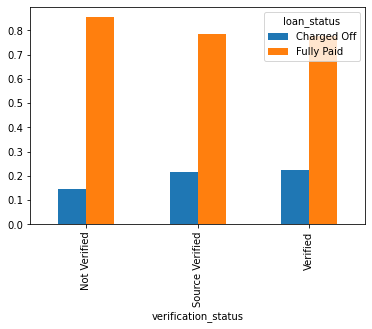

In [46]:
pd.crosstab(index = df["verification_status"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")
plt.show()

### Purpose

debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64


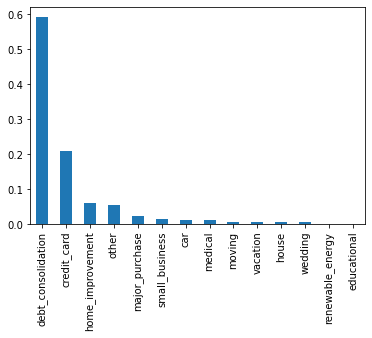

In [47]:
print(df["purpose"].value_counts(dropna=False))
df["purpose"].value_counts(dropna=False,normalize=True).plot(kind = "bar")
plt.show()

###### Most of the loans are taken for debt consolidation followed by credit card and home improvement

In [48]:
pd.crosstab(index = df["purpose"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,Charged Off,Fully Paid
purpose,,
car,13.476687,86.523313
credit_card,16.711837,83.288163
debt_consolidation,20.741385,79.258615
educational,16.342412,83.657588
home_improvement,17.007907,82.992093
house,19.718310,80.281690
major_purchase,16.473265,83.526735
medical,21.711153,78.288847
moving,23.475823,76.524177


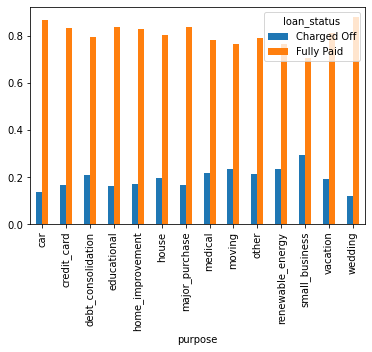

In [49]:
pd.crosstab(index = df["purpose"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")
plt.show()

### Loan Status

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64


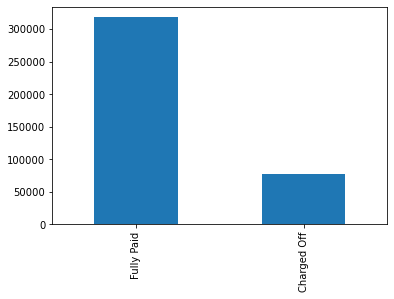

In [50]:
print(df["loan_status"].value_counts(dropna=False, normalize=True)  * 100)
df["loan_status"].value_counts(dropna=False).plot(kind = "bar")
plt.show()

###### We can see that data is imbalanced here. 80% loans are fully paid and 20% loans are charged_off. 

### Dti
###### Dti is monthly total debt payment / monthly income excluding mortgages

In [51]:
df["dti"].describe()

count    396030.000000
mean         17.379514
std          18.019092
min           0.000000
25%          11.280000
50%          16.910000
75%          22.980000
max        9999.000000
Name: dti, dtype: float64

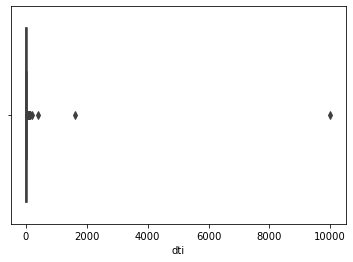

In [52]:
sns.boxplot((df["dti"]))
plt.show()

###### Seems there are many outliers in Dti column

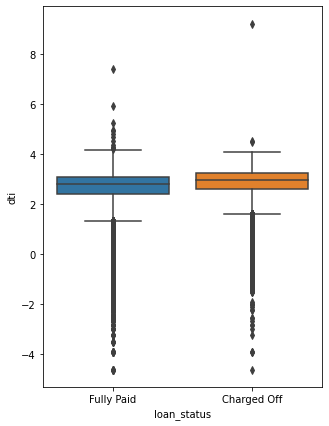

In [53]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(df[df["dti"]>0]["dti"]),
            x=df["loan_status"])
plt.show()

### Earliest Credit Line and Loan Issued Month

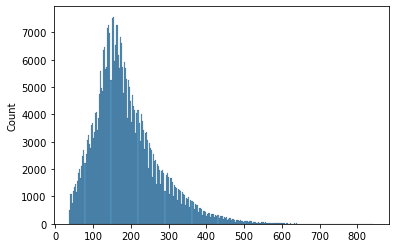

In [54]:
sns.histplot(((pd.to_datetime(df["issue_d"]) -pd.to_datetime(df["earliest_cr_line"]))/np.timedelta64(1, 'M')))
plt.show()

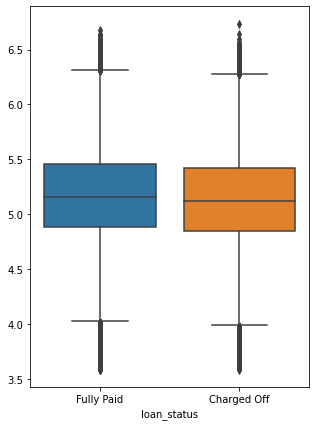

In [55]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(((pd.to_datetime(df["issue_d"]) -pd.to_datetime(df["earliest_cr_line"]))/np.timedelta64(1, 'M'))),
            x=df["loan_status"])
plt.show()

### Open Credit Lines(open_acc)

In [56]:
df.groupby("loan_status")["open_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,11.602513,5.288507,0.0,8.0,11.0,14.0,76.0
Fully Paid,318357.0,11.240067,5.097647,0.0,8.0,10.0,14.0,90.0


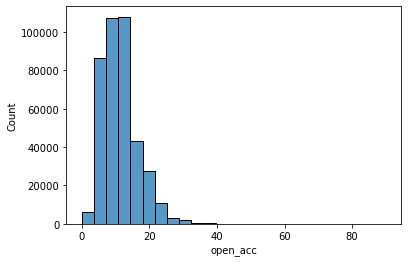

In [57]:
sns.histplot(df["open_acc"],bins = 25)
plt.show()

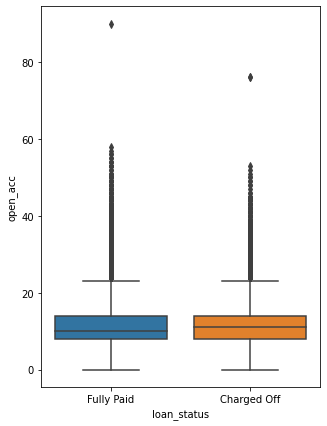

In [58]:
plt.figure(figsize=(5,7))
sns.boxplot(y= df["open_acc"],x=df["loan_status"])
plt.show()

### No. of Derogatory Public Records(pub_rec)

In [59]:
df.groupby("loan_status")["pub_rec"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,0.199606,0.648283,0.0,0.0,0.0,0.0,86.0
Fully Paid,318357.0,0.172966,0.497637,0.0,0.0,0.0,0.0,24.0


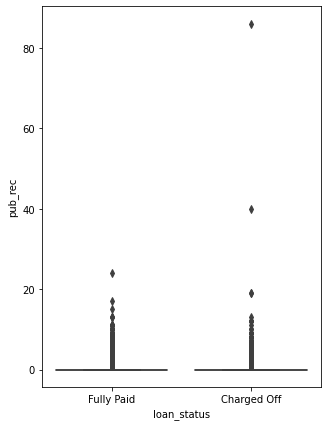

In [60]:
plt.figure(figsize=(5,7))
sns.boxplot(y= df["pub_rec"], x=df["loan_status"])
plt.show()


In [61]:
df["pub_rec"].value_counts(dropna=False)

0.0     338272
1.0      49739
2.0       5476
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
13.0         4
12.0         4
19.0         2
40.0         1
17.0         1
86.0         1
24.0         1
15.0         1
Name: pub_rec, dtype: int64

In [62]:
pd.crosstab(index = df["pub_rec"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,Charged Off,Fully Paid
pub_rec,,
0.0,19.315521,80.684479
1.0,21.047870,78.952130
2.0,22.899927,77.100073
3.0,22.353715,77.646285
4.0,27.514231,72.485769
5.0,23.628692,76.371308
6.0,25.409836,74.590164
7.0,28.571429,71.428571
8.0,17.647059,82.352941


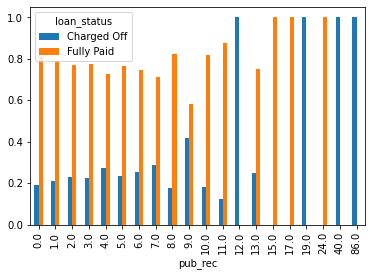

In [63]:
pd.crosstab(index = df["pub_rec"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")
plt.show()

### Total credit revolving balance(revol_bal)

In [64]:
df.groupby("loan_status")["revol_bal"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15390.454701,18203.387930,0.0,6150.0,11277.0,19485.0,1030826.0
Fully Paid,318357.0,15955.327918,21132.193457,0.0,5992.0,11158.0,19657.0,1743266.0


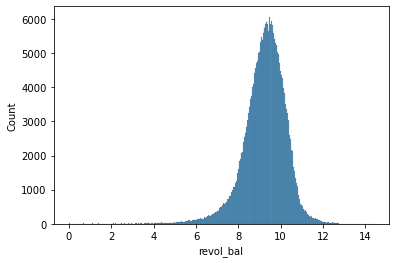

In [65]:
sns.histplot(np.log(df["revol_bal"]))
plt.show()

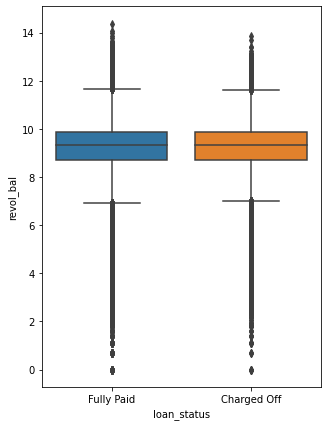

In [66]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["revol_bal"]),x=df["loan_status"])
plt.show()

### Revolving line utilization rate(revol_util)

In [67]:
df.groupby("loan_status")["revol_util"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77610.0,57.869824,23.492176,0.0,41.2,59.3,76.2,148.0
Fully Paid,318144.0,52.796918,24.578304,0.0,34.6,53.7,72.0,892.3


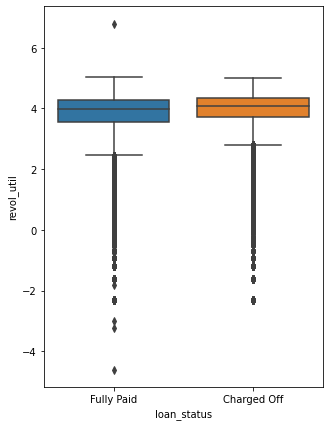

In [68]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["revol_util"]),x=df["loan_status"])
plt.show()

### total_acc
###### The total number of credit lines currently in the borrower's credit file

In [69]:
df.groupby("loan_status")["total_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,24.984152,11.913692,2.0,16.0,23.0,32.0,151.0
Fully Paid,318357.0,25.519800,11.878117,2.0,17.0,24.0,32.0,150.0


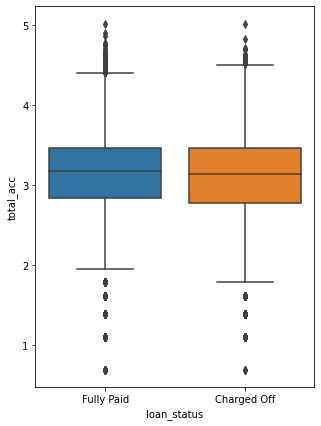

In [70]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["total_acc"]),x=df["loan_status"])
plt.show()

### Initial Listing Status(initial_list_status)

In [71]:
df["initial_list_status"].value_counts()

f    238066
w    157964
Name: initial_list_status, dtype: int64

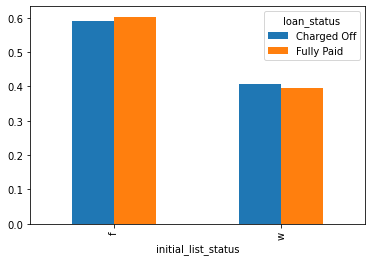

In [72]:
pd.crosstab(index = df["initial_list_status"],
            columns= df["loan_status"],normalize= "columns").plot(kind = "bar")
plt.show()

### application_type
###### Indicates whether the loan is an individual application or a joint application with two co-borrowers

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64


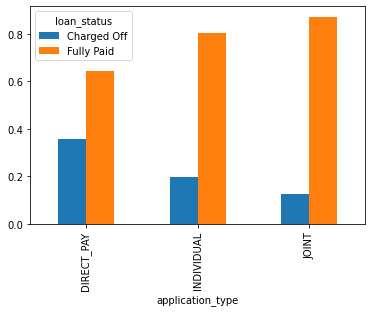

In [73]:
print(df["application_type"].value_counts(dropna=False))

pd.crosstab(index = df["application_type"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")
plt.show()

### Number of mortgage accounts(mort_acc)

In [74]:
df.groupby("loan_status")["mort_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,72123.0,1.501213,1.974353,0.0,0.0,1.0,2.0,23.0
Fully Paid,286112.0,1.892836,2.182456,0.0,0.0,1.0,3.0,34.0


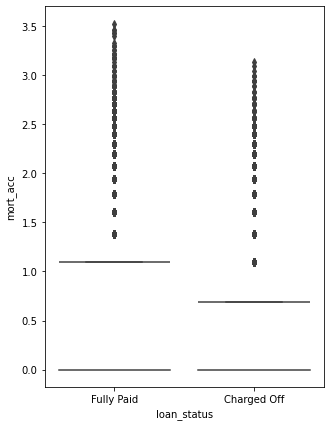

In [75]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["mort_acc"]),x=df["loan_status"])
plt.show()

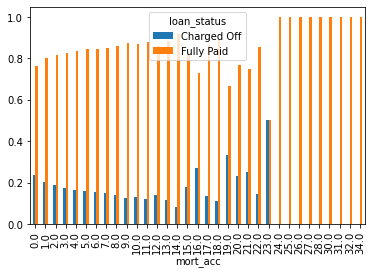

In [76]:
pd.crosstab(index = df["mort_acc"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")
plt.show()

### Number of public record bankruptcies(pub_rec_bankruptcies)

In [77]:
df["pub_rec_bankruptcies"].value_counts()

0.0    350380
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: pub_rec_bankruptcies, dtype: int64

loan_status           Charged Off  Fully Paid
pub_rec_bankruptcies                         
0.0                     19.499115   80.500885
1.0                     20.394952   79.605048
2.0                     23.226854   76.773146
3.0                     21.082621   78.917379
4.0                     31.707317   68.292683
5.0                     15.625000   84.375000
6.0                     28.571429   71.428571
7.0                     25.000000   75.000000
8.0                     50.000000   50.000000
All                     19.617441   80.382559


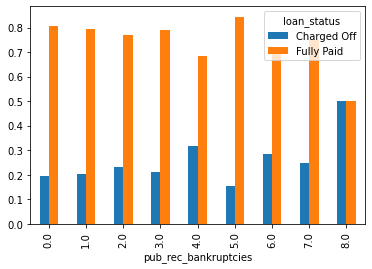

In [78]:
print(pd.crosstab(index = df["pub_rec_bankruptcies"],
            columns= df["loan_status"],normalize= "index", margins = True)*100)
pd.crosstab(index = df["pub_rec_bankruptcies"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")
plt.show()

### Address of the individual

In [79]:
df['address'].sample()

303780    329 Morris Springs\r\nPort Reginaldburgh, SC 2...
Name: address, dtype: object

In [80]:
#spliting pin codes of location
df["address"] = df["address"].str.split().apply(lambda x:x[-1])
df['pin_code'] = df['address']

In [81]:
df["address"].value_counts()

70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: address, dtype: int64

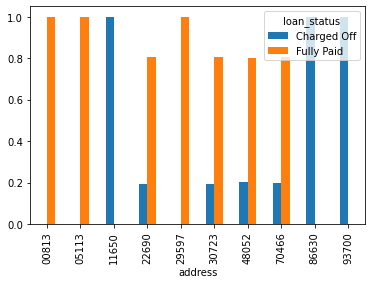

In [82]:
pd.crosstab(index = df["address"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")
plt.show()

### Missing Value Treatment

In [83]:
#mort_acc is having highest missing values so imputing it 
Imputer = SimpleImputer(strategy="most_frequent")
df["mort_acc"] = Imputer.fit_transform(df["mort_acc"].values.reshape(-1,1))

In [84]:
#Dropping the other missing values which are not significant in numbers
df.dropna(inplace = True)

In [85]:
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_title               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
title                   0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
pin_code                0
dtype: int64

###### We can see no missing values are present now

In [86]:
#Dropping unimportant columns
df.drop(["title","issue_d","earliest_cr_line","initial_list_status", "address"],axis = 1, inplace=True)


In [87]:
df["loan_status"].replace({"Fully Paid":0, "Charged Off" : 1},inplace=True)
term_values = {' 36 months': 36, ' 60 months': 60}
df['term'] = df['term'].map(term_values)

In [88]:
#Columns for Target Encoding
target_enc = ['sub_grade','grade','term', 'emp_title','emp_length',
              'home_ownership', 'verification_status', 'purpose', 'application_type']

In [89]:
df.sample(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,pin_code
166404,10575.0,36,14.09,361.90,B,B5,"Dynamic Products, inc",10+ years,MORTGAGE,70000.0,...,10.77,9.0,0.0,11699.0,51.1,14.0,INDIVIDUAL,1.0,0.0,05113
349575,10000.0,60,12.99,227.48,C,C1,Senior Disability Claim Case Manager,4 years,RENT,63000.0,...,28.11,16.0,0.0,9628.0,46.5,35.0,INDIVIDUAL,0.0,0.0,48052
224032,14475.0,60,24.50,420.63,F,F3,Executive Secretary,6 years,MORTGAGE,54000.0,...,30.62,7.0,0.0,3200.0,45.1,19.0,INDIVIDUAL,1.0,0.0,70466


In [90]:
for col in target_enc:
    TEncoder = TargetEncoder()
    df[col] = TEncoder.fit_transform(df[col],df["loan_status"])

### Outlier Treatment

In [91]:
def outlier_remover(a,df):

    q1 = a.quantile(.25)
    q3 = a.quantile(.75)
    iqr = q3 - q1

    maxx = q3 + 1.5 * iqr
    minn = q1 - 1.5 * iqr

    return df.loc[(a>=minn) & (a<=maxx)]

In [92]:
cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc','revol_bal', 'revol_util', 'total_acc']
for col in cols:
    df = outlier_remover(df[col],df)

In [93]:
df.drop(["mort_acc","pub_rec_bankruptcies"],axis = 1 , inplace=True)
df.drop(["pub_rec"],axis = 1 , inplace=True)

### Correlation Metrix

In [94]:
df.corr()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,application_type
loan_amnt,1.000000,0.408638,0.168781,0.951679,0.174968,0.181256,-0.021457,-0.080591,-0.168949,0.446878,0.305527,0.073725,0.042159,0.049844,0.169153,0.438564,0.088513,0.203336,-0.021133
term,0.408638,1.000000,0.418695,0.159371,0.445897,0.457050,0.077721,-0.044951,-0.103021,0.110698,0.238423,0.175521,0.040094,0.078248,0.067573,0.140657,0.049039,0.099709,-0.011144
int_rate,0.168781,0.418695,1.000000,0.160404,0.944215,0.966671,0.154289,-0.004877,0.077362,-0.089686,0.219072,0.244234,0.163174,0.171677,0.003239,0.022013,0.308265,-0.051464,-0.000055
installment,0.951679,0.159371,0.160404,1.000000,0.152881,0.158233,-0.028617,-0.072328,-0.136646,0.428694,0.278401,0.052594,0.049482,0.049014,0.161249,0.423229,0.116110,0.179739,-0.018396
grade,0.174968,0.445897,0.944215,0.152881,1.000000,0.975643,0.169641,-0.000060,0.070663,-0.072968,0.220477,0.254091,0.164837,0.166399,0.004101,0.006434,0.262086,-0.044410,-0.002279
sub_grade,0.181256,0.457050,0.966671,0.158233,0.975643,1.000000,0.174599,0.000243,0.073481,-0.074899,0.230749,0.260339,0.169602,0.171882,0.004115,0.009346,0.273176,-0.045136,-0.001966
emp_title,-0.021457,0.077721,0.154289,-0.028617,0.169641,0.174599,1.000000,-0.009849,0.044018,-0.158565,0.043192,0.540441,0.039953,0.101221,-0.012573,-0.064347,0.014994,-0.047282,-0.001296
emp_length,-0.080591,-0.044951,-0.004877,-0.072328,-0.000060,0.000243,-0.009849,1.000000,0.165461,-0.107411,-0.025566,0.015958,-0.001932,-0.022939,-0.033103,-0.093906,-0.021177,-0.108994,0.004039
home_ownership,-0.168949,-0.103021,0.077362,-0.136646,0.070663,0.073481,0.044018,0.165461,1.000000,-0.237607,-0.033256,0.062332,0.041736,0.011631,-0.123318,-0.167959,0.006184,-0.226385,0.013117
annual_inc,0.446878,0.110698,-0.089686,0.428694,-0.072968,-0.074899,-0.158565,-0.107411,-0.237607,1.000000,0.112898,-0.077534,-0.007988,-0.219789,0.172538,0.317790,0.025315,0.279036,0.001166


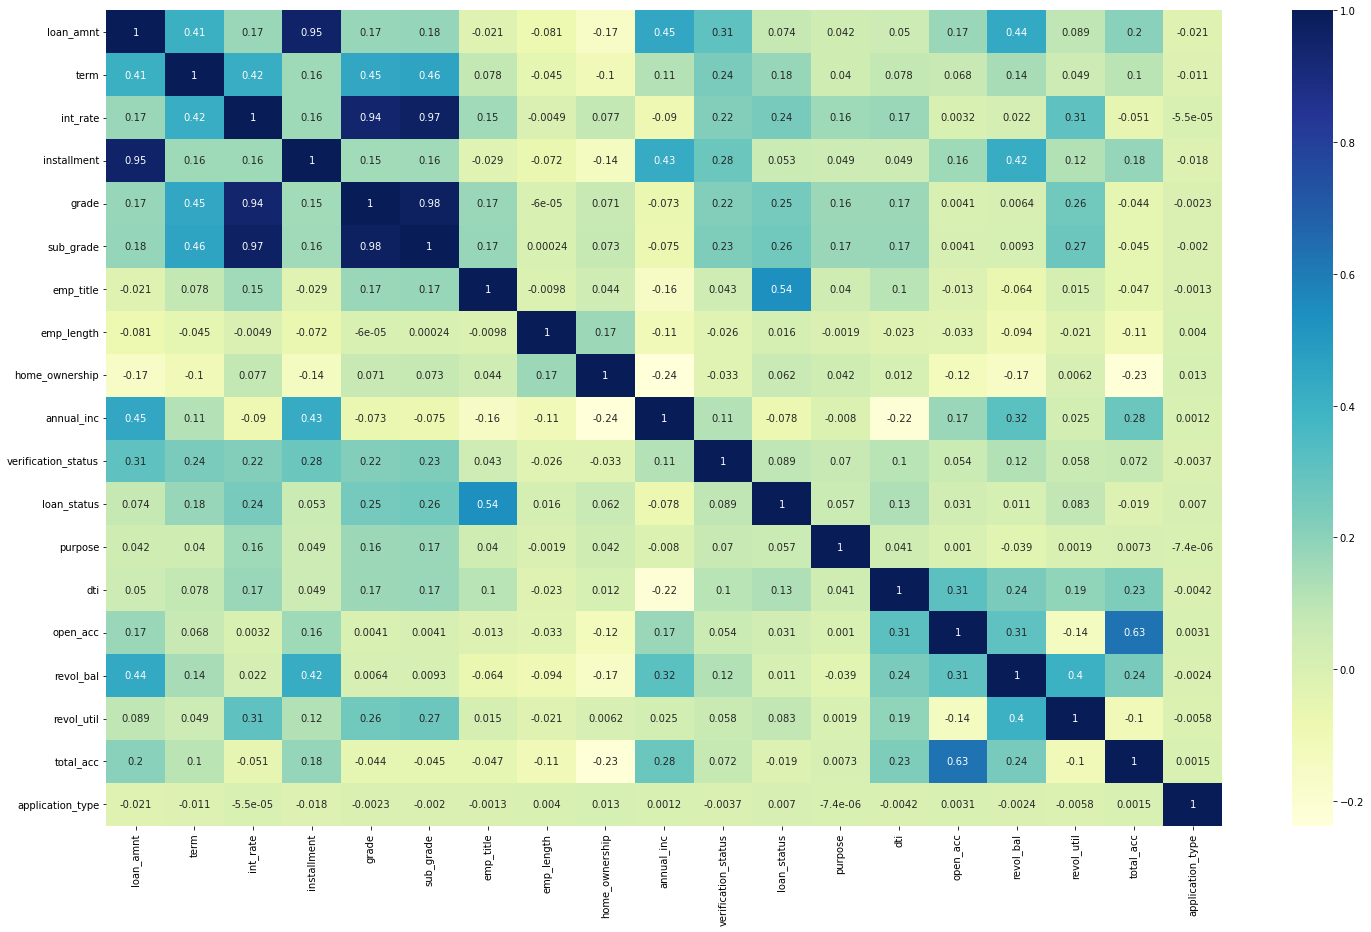

In [95]:
# Correlation Plot above of as a Heatmap -
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

### Train Test Spilit

In [96]:
X = df.drop(["loan_status"],axis = 1)
y = df["loan_status"]

In [97]:
X_train , X_test , y_train , y_test = train_test_split(X,y,
                                                      random_state=3,
                                                      test_size=0.2)

### Logistic Regression on Non-Standardised Data

In [98]:
logreg = LogisticRegression(class_weight="balanced")

In [99]:
logreg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [100]:
print("Accuracy: ",logreg.score(X_test,y_test))
print("f1_score: ",f1_score(y_test,logreg.predict(X_test)))
print("recall_score: ",recall_score(y_test,logreg.predict(X_test)))
print("precision_score: ",precision_score(y_test,logreg.predict(X_test)))

Accuracy:  0.6573666635458603
f1_score:  0.43549796904725174
recall_score:  0.69267255479228
precision_score:  0.31758530183727035


### Logistic Regression on Standardised Data 

In [101]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [102]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [103]:
LR_Std = LogisticRegression(C=1.0)
LR_Std.fit(X_train,y_train)
print("Accuracy: ",LR_Std.score(X_test,y_test))
print("f1_score: ",f1_score(y_test,LR_Std.predict(X_test)))
print("recall_score: ",recall_score(y_test,LR_Std.predict(X_test)))
print("precision_score: ",precision_score(y_test,LR_Std.predict(X_test)))

Accuracy:  0.880457510220641
f1_score:  0.6446825286396735
recall_score:  0.5683676807327446
precision_score:  0.7446694524804457


### Logistic Regression after Data Balancing

In [104]:
X_train.shape, y_train.shape

((256340, 19), (256340,))

In [105]:
Smote = SMOTE(k_neighbors=5)
X_sm , y_sm = Smote.fit_resample(X_train,y_train)

In [106]:
X_sm.shape, y_sm.shape

((414336, 19), (414336,))

In [107]:
logregbal = LogisticRegression(max_iter=1000,class_weight="balanced")

In [108]:
cross_val_score(estimator = logregbal,
                cv=5,
                X = X_sm,
                y = y_sm,
                scoring= "f1")

array([0.83349552, 0.84270746, 0.84257655, 0.8430096 , 0.84181501])

In [109]:
cross_val_score(estimator = logregbal,
                cv=5,
                X = X_sm,
                y = y_sm,
                scoring= "precision")

array([0.85118374, 0.85190392, 0.8518884 , 0.85015831, 0.85123498])

In [110]:
cross_val_score(estimator = logregbal,
                cv=5,
                X = X_sm,
                y = y_sm,
                scoring= "recall")

array([0.81652749, 0.83370743, 0.83346608, 0.83598011, 0.83260125])

In [111]:
logregbal.fit(X_sm, y_sm)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [112]:
print("Accuracy: ",logregbal.score(X_test,y_test))
print("f1_score: ",f1_score(y_test,logregbal.predict(X_test)))
print("recall_score: ",recall_score(y_test,logregbal.predict(X_test)))
print("precision_score: ",precision_score(y_test,logregbal.predict(X_test)))

Accuracy:  0.8479543113940642
f1_score:  0.6724045185583647
recall_score:  0.8177952240758914
precision_score:  0.5709065996802923


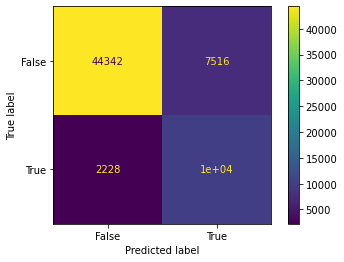

In [120]:
cm_display  = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, 
                                                          logregbal.predict(X_test)),display_labels=[False,True])
cm_display.plot()
plt.show()

In [113]:
logregbal.coef_

array([[ 0.07869517,  0.23414051,  0.00647741,  0.07724623, -0.01974941,
         0.40900004,  1.54214929,  0.02964535,  0.13705645, -0.02238216,
         0.0623842 ,  0.06121855,  0.16782477,  0.21481018, -0.0813323 ,
         0.19517393, -0.1147035 ,  0.03461226,  0.82717503]])

In [114]:
df.drop(["loan_status"], axis = 1).columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'dti', 'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 'application_type', 'pin_code'],
      dtype='object')

In [115]:
feature_importance = pd.DataFrame(index = df.drop(["loan_status"],
                                                  axis = 1).columns,
                                  data = logregbal.coef_.ravel()).reset_index()
feature_importance

,index,0
0,loan_amnt,0.078695
1,term,0.234141
2,int_rate,0.006477
3,installment,0.077246
4,grade,-0.019749
5,sub_grade,0.409000
6,emp_title,1.542149
7,emp_length,0.029645
8,home_ownership,0.137056
9,annual_inc,-0.022382


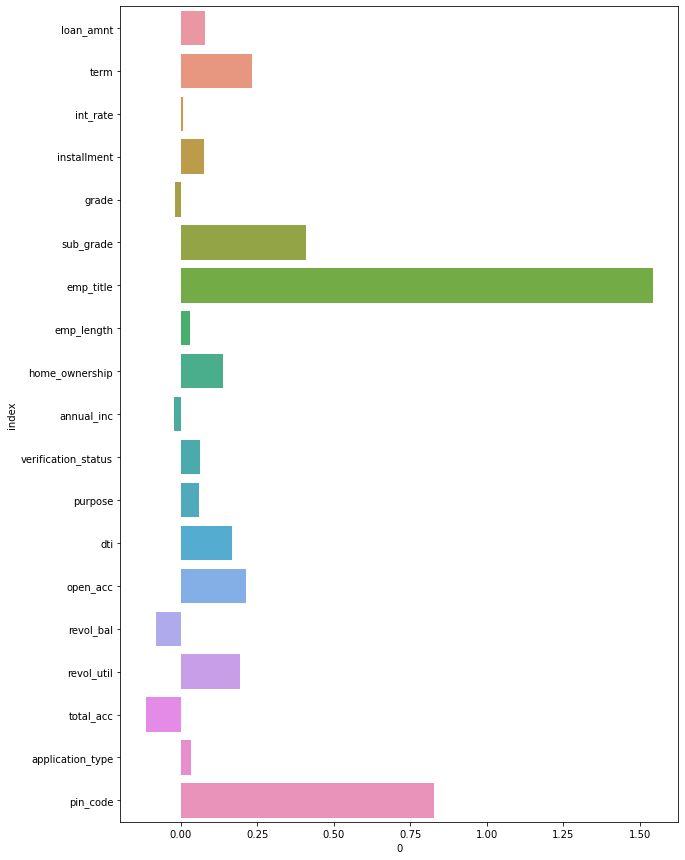

In [116]:
plt.figure(figsize=(10,15))
sns.barplot(y = feature_importance["index"],x =  feature_importance[0])
plt.show()